In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim

from pack2.utils import get_dataset

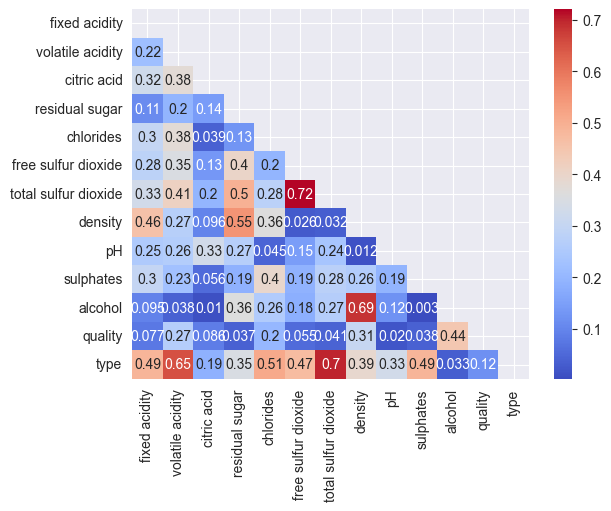

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = get_dataset()

y = df.pop("quality").values
X = df.values
tmp = []
for i in y:
    t = [0] * 10
    t[i] = 1
    tmp.append(t)
y = tmp

In [3]:
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True
)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]

In [4]:
model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
).to(device)

n_epochs = 100
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_quality = []
    with torch.no_grad():
        for features, quality in loader:
            features, quality = features.to(device), quality.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            _, quality = torch.max(quality, 1)
            correct += (preds == quality).sum().item()
            total += quality.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_quality.extend(quality.cpu().numpy())
    accuracy = correct / total * 100
    return accuracy, np.array(all_quality), np.array(all_preds)


In [13]:

from tqdm import tqdm

train_loss_history = []
test_accuracy_history = []
test_loss_history = []


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        print(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    test_accuracy, _, _ = evaluate(model, test_loader)
    test_accuracy_history.append(test_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



1.342191219329834
1.3637919425964355
1.5017403364181519
1.3724571466445923
1.4138058423995972
1.2968388795852661
1.204640507698059
1.2391116619110107
1.174365758895874
1.2246074676513672
1.2809321880340576
1.3548791408538818
1.5111308097839355
1.2800391912460327
1.2042583227157593
1.253829836845398
1.3459290266036987
1.3693804740905762
1.1679117679595947
1.1207499504089355
1.216066598892212
1.3960866928100586
1.3822038173675537
1.2034450769424438
1.2026320695877075
1.146553874015808
1.1942286491394043
1.3296175003051758
1.322705864906311
1.5163170099258423
1.2782847881317139
1.1539273262023926
1.3748235702514648
1.2794544696807861
1.33798348903656
1.18976628780365
1.302001714706421
1.4689069986343384
1.2702126502990723
1.231855869293213
1.2347350120544434
1.2514845132827759
1.265165090560913
1.2928653955459595
1.2703365087509155
1.1401638984680176
1.365455150604248
1.1993436813354492
1.1395299434661865
1.154375433921814
1.1654523611068726
1.2503588199615479
1.2757532596588135
1.1442919

KeyboardInterrupt: 

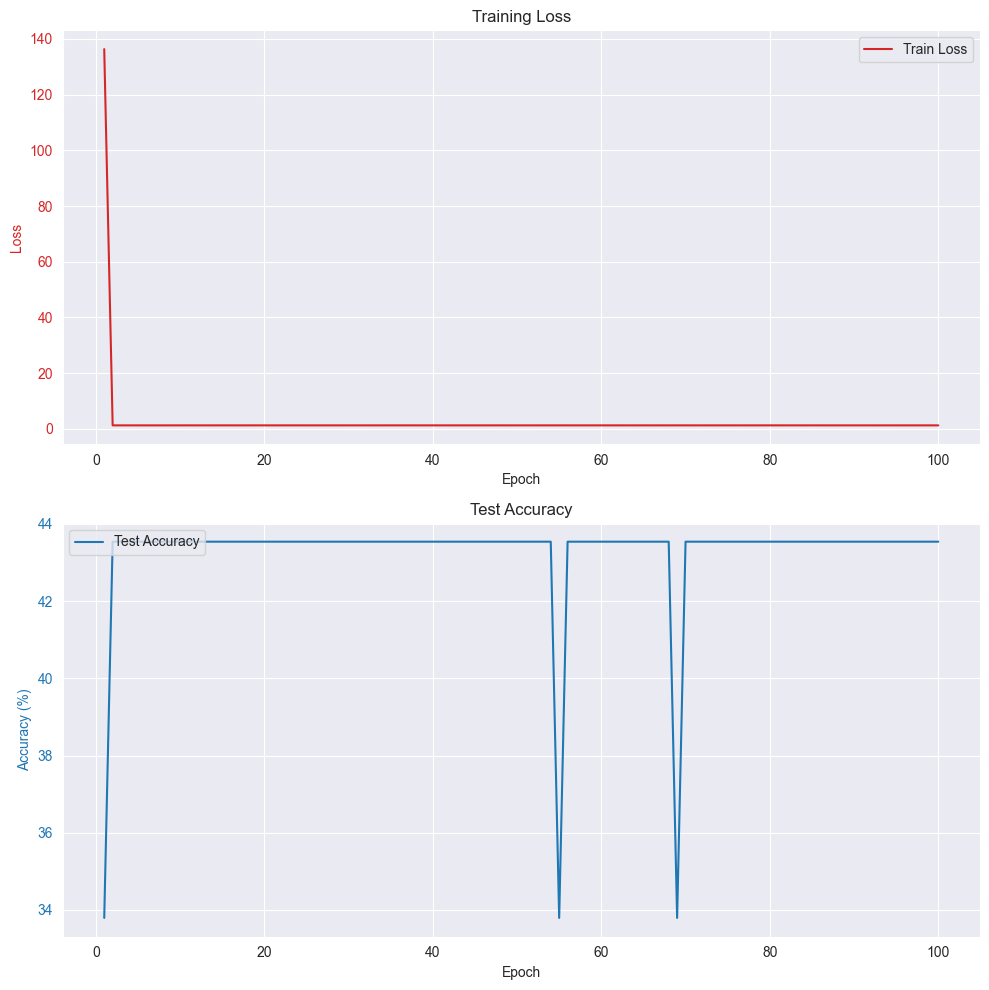

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, n_epochs + 1), train_loss_history, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
ax1.set_title("Training Loss")

color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, n_epochs + 1), test_accuracy_history, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title("Test Accuracy")

plt.tight_layout()
plt.show()

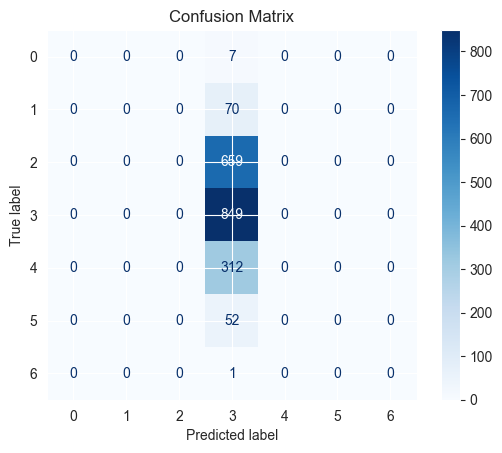

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, y_true, y_pred = evaluate(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [9]:
import pandas as pd

model.eval()
x = X_test
y_expected = y_test
y_pred = model(x)
res = {
    "prediction": [],
    "expected": [],
}
for i in range(len(y_pred)):
    res['prediction'].append(y_pred[i].detach().numpy().argmax())
    res['expected'].append(y_expected[i].detach().numpy().argmax())

df = pd.DataFrame(
    res
)

df


,prediction,expected
0,6,4
1,6,6
2,6,5
3,6,6
4,6,6
...,...,...
1945,6,6
1946,6,8
1947,6,5
1948,6,6


In [10]:
from sklearn.metrics import classification_report

report = classification_report(res["expected"], res["prediction"], zero_division=0)
print(report)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        70
           5       0.00      0.00      0.00       659
           6       0.44      1.00      0.61       849
           7       0.00      0.00      0.00       312
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00         1

    accuracy                           0.44      1950
   macro avg       0.06      0.14      0.09      1950
weighted avg       0.19      0.44      0.26      1950

